In [ ]:
install.packages("gridExtra")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(gridExtra)

ERROR: ignored

In [ ]:
library(tidyverse)
library(mgcv)
library(readr)
library(ggplot2)

par(mfrow = c(1, 1))  # Set the figure size (e.g., 1 row and 1 column)
options(scipen = 999)  # Update the font size

theme_set(theme_grey())  # Use the 'ggplot' style
data <- read_csv("regional_data (1).csv",col_types = cols(), show_col_types = FALSE)
unique(data$"Région")

New names:
• `` -> `...1`


[1] "Pays_de_la_Loire"           "Nouvelle_Aquitaine"        
 [3] "Auvergne_Rhone_Alpes"       "Provence_Alpes_Cote_d_Azur"
 [5] "Hauts_de_France"            "Ile_de_France"             
 [7] "Normandie"                  "Bretagne"                  
 [9] "Occitanie"                  "Centre_Val_de_Loire"       
[11] "Bourgogne_Franche_Comte"    "Grand_Est"

In [ ]:
|column_values <- data$"Région"
print(data)

# A tibble: 1,051,716 × 5
    ...1 `Date - Heure`      Région              `Consommation (MW)` Température
   <dbl> <dttm>              <chr>                             <dbl>       <dbl>
 1     0 2014-01-01 00:00:00 Pays_de_la_Loire                   3661        6.40
 2     1 2014-01-01 00:00:00 Nouvelle_Aquitaine                 5845        8.16
 3     2 2014-01-01 00:00:00 Auvergne_Rhone_Alp…                8272        7.33
 4     3 2014-01-01 00:00:00 Provence_Alpes_Cot…                6035        5.55
 5     4 2014-01-01 00:00:00 Hauts_de_France                    6191        6   
 6     5 2014-01-01 00:00:00 Ile_de_France                      9164        6.70
 7     6 2014-01-01 00:00:00 Normandie                          3589        6.25
 8     7 2014-01-01 00:00:00 Bretagne                           3112        8.70
 9     8 2014-01-01 00:00:00 Occitanie                          5492        5.41
10     9 2014-01-01 00:00:00 Centre_Val_de_Loire                2480        6.25
# 

In [ ]:
data <- read_csv("regional_data (1).csv",col_types = cols(), show_col_types = FALSE)
subset_data <- subset(data, data[["Région"]] == "Provence_Alpes_Cote_d_Azur")

New names:
• `` -> `...1`


Warning message:
“Use of `subset_data[["Date - Heure"]]` is discouraged.
ℹ Use `.data[["Date - Heure"]]` instead.”
Warning message:
“Use of `subset_data[["Consommation (MW)"]]` is discouraged.
ℹ Use `.data[["Consommation (MW)"]]` instead.”


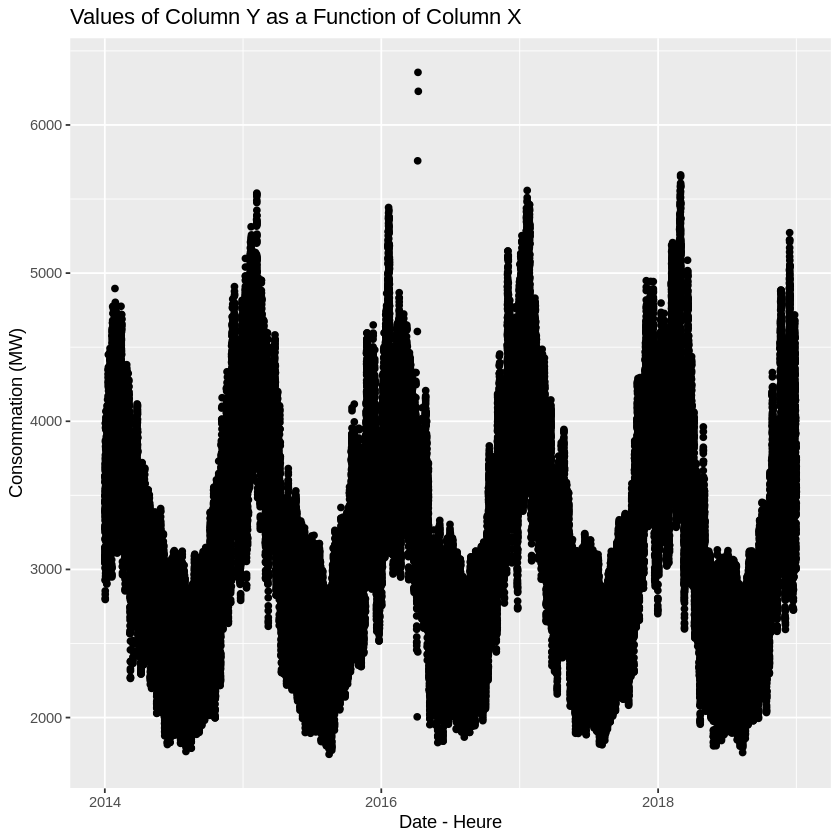

In [ ]:
ggplot(subset_data, aes(x = subset_data[["Date - Heure"]], y = subset_data[["Consommation (MW)"]])) +
  geom_point() +
  labs(x = "Date - Heure", y = "Consommation (MW)") +
  ggtitle("Values of Column Y as a Function of Column X")

In [ ]:
names(subset_data)[2] <- "date"
names(subset_data)[4] <- "consumption"
subset_data$year <- format(subset_data$date, "%Y")
subset_data$month <- format(subset_data$date, "%m")
subset_data$day <- format(subset_data$date, "%d")
subset_data$hour <- format(subset_data$date, "%H")
subset_data$minute <- format(subset_data$date, "%M")
subset_data$half_hour <- as.integer(format(subset_data$date, "%M")) %/% 30

subset_data$day <- as.integer(subset_data$day) # Convert to factor
subset_data$month <- as.integer(subset_data$month) # Convert to factor
subset_data$year <- as.integer(subset_data$year)
subset_data$hour <- as.integer(subset_data$hour)
subset_data$minute <- as.integer(subset_data$minute)

In [ ]:
n_rows <- nrow(subset_data)
train_percent <- 0.8
split_index <- round(train_percent * n_rows)
train_data <- subset_data[1:split_index, ]
test_data <- subset_data[(split_index + 1):n_rows, ]

In [ ]:
train_data <- train_data %>%
  mutate(
    lag = lag(consumption),
    lag2 = lag(consumption, n = 2L),
    lag3 = lag(consumption, n = 3L),
)
test_data <- test_data %>%
  mutate(
    lag = lag(consumption),
    lag2 = lag(consumption, n = 2L),
    lag3 = lag(consumption, n = 3L),
)
train_data <- train_data %>%
  drop_na(lag, lag2, lag3)
test_data <- test_data %>%
  drop_na(lag, lag2, lag3)
gam_mod1 <- gam(
  consumption ~ s(lag) + s(lag2) +
    s(lag3) +s(Température) ,
  data = train_data
)

train_data <- train_data %>%
  mutate(
    fitted_gam = fitted(gam_mod1)
)

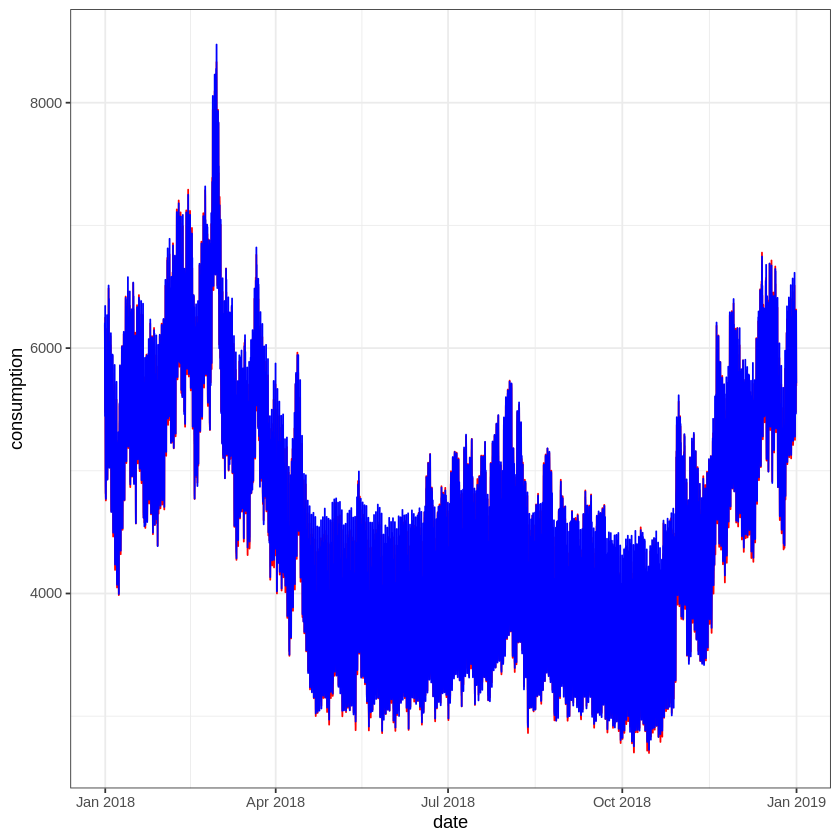

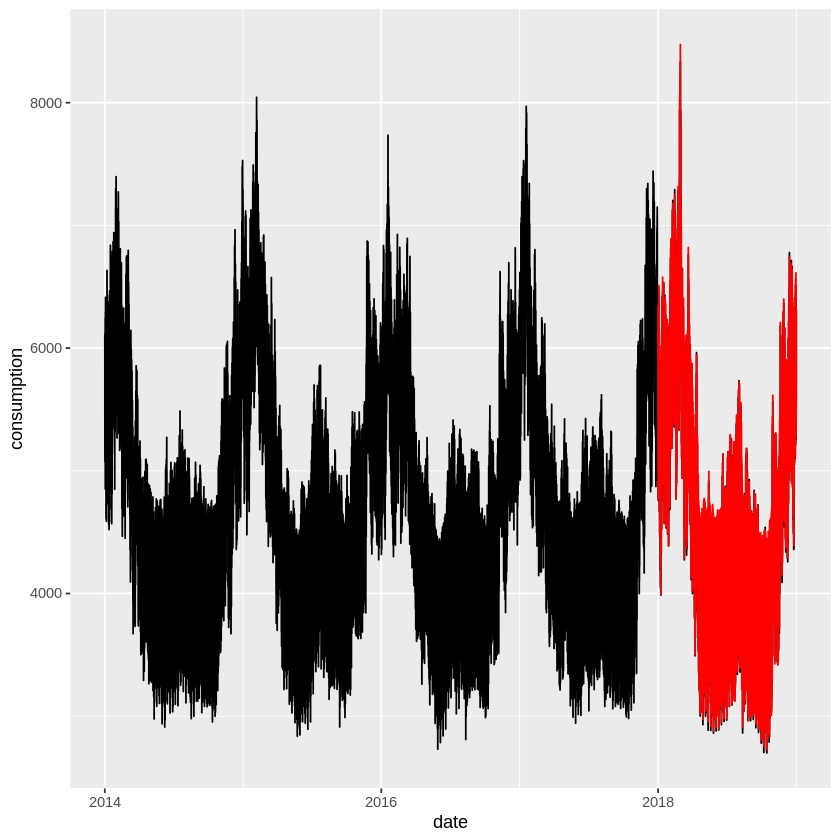

In [ ]:
test_data <- test_data %>%
  mutate(
     pred_gam = predict(gam_mod1, newdata = test_data)
  )
ggplot(test_data, aes(x = date)) +
  geom_line(aes(y = consumption, color = "Valeurs réelles"),color ="red") +
  geom_line(aes(y = pred_gam, color = "Valeurs prédites"),color ="blue") +
  labs(color = "Variable") +
  theme_bw()

subset_data %>%
  ggplot(aes(date, consumption)) +
  geom_line() +
  geom_line(aes(date, pred_gam), data = test_data, color = "red")
write.csv(test_data, "test_data.csv", row.names = FALSE)

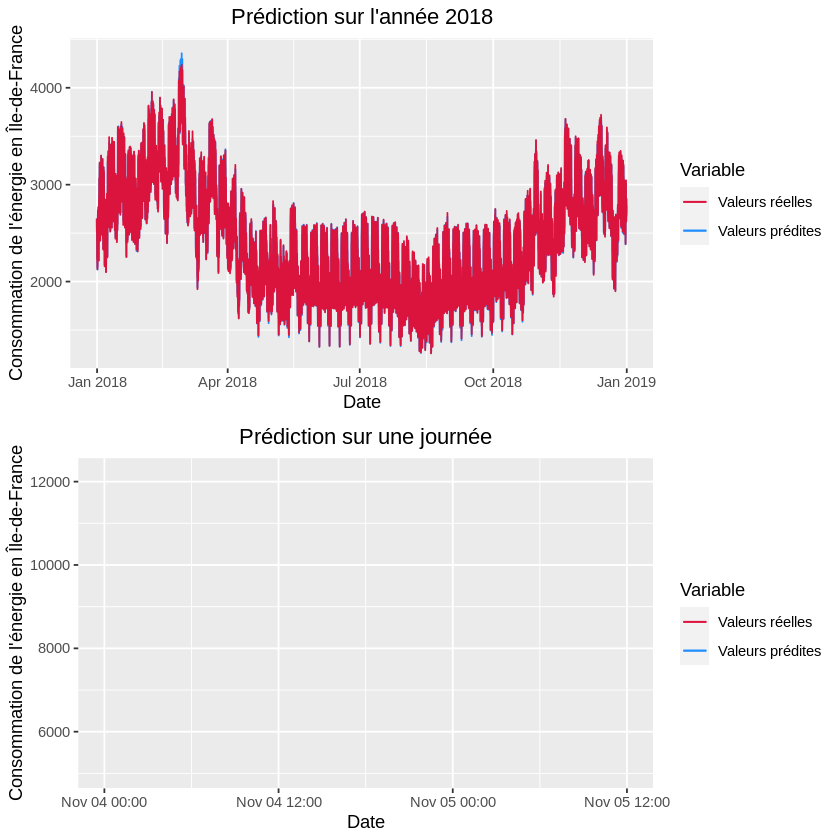

In [ ]:
subset_test_data <- subset(test_data, date >= "2018-01-03 03:00:00" & date <= "2018-01-11 11:00:00")

library(ggplot2)

p <- ggplot(test_data, aes(x = date)) +
  geom_line(aes(y = consumption, color = "Valeurs réelles")) +
  geom_line(aes(y = pred_gam, color = "Valeurs prédites")) +
  labs(
    x = "Date",
    y = "Consommation de l'énergie en Île-de-France",
    color = "Variable"
  ) +
  scale_color_manual(
    values = c("Valeurs réelles" = rgb(0.12, 0.56, 1.0), "Valeurs prédites" = rgb(0.86, 0.08, 0.24)),
    labels = c("Valeurs réelles", "Valeurs prédites")
  ) +
  labs(title = "Prédiction sur l'année 2018") +
  theme(plot.title = element_text(hjust = 0.5))
zoomed <- p +
  coord_cartesian(xlim = c(as.POSIXct("2018-11-04 00:00:00"), as.POSIXct("2018-11-05 12:00:00")),
                  ylim = c(5000, 12200)) +
  labs(title = "Prédiction sur une journée") +
  theme(plot.title = element_text(hjust = 0.5))
gridExtra::grid.arrange(p, zoomed, ncol = 1)

In [ ]:
updated_data <- test_data %>%
  slice(-(1:11))


In [ ]:
library(dplyr)
library(lubridate)

date_str <- '2018-01-01'
date <- as.Date(date_str, '%Y-%m-%d')
data1 <- data.frame(date = as.Date(character()), consumption = numeric(), prediction = numeric())
for (i in seq(1, nrow(updated_data), 48)) {
  chunk <- updated_data[(i-1):(i-1+47), ]
  mean_value <- mean(chunk$consumption)
  data1[(i-1)/48, 'consumption'] <- mean_value
  mean_value1 <- mean(chunk$pred_gam)
  data1[(i-1)/48, 'prediction'] <- mean_value1
  data1[(i-1)/48, 'date'] <- date
  date <- date %m+% days(1)
}


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




ERROR: ignored

In [ ]:
new_row <- data.frame(date = as.Date(date_str, '%Y-%m-%d'), consumption = 8329.957, prediction= 8356.028)
data1 <- rbind(new_row, data1)


In [ ]:
mape_list <- list()
mae_list <- list()
rmse_list <- list()

In [ ]:
n <- nrow(test_data)
mape <- (1/n) * sum(abs((test_data$consumption - test_data$pred_gam) / test_data$consumption)) * 100
print(mape)

[1] 2.178111


In [ ]:
mae <- function(y_true, y_pred) {
  absolute_error <- abs(y_true - y_pred)
  mean_absolute_error <- mean(absolute_error)
  mae_percentage <- (mean_absolute_error / mean(y_true)) * 100
  return(mae_percentage)
}

mae_percentage <- mae(test_data$consumption, test_data$pred_gam)
print(mae_percentage)

[1] 1.496119


In [ ]:
test_data$squared_error <- (test_data$consumption - test_data$pred_gam)^2
rmse <- sqrt(mean(test_data$squared_error))
rmse_percentage <- (rmse / mean(test_data$consumption)) * 100
rmse_percentage

[1] 2.085509

In [ ]:
mape_list <- c(mape_list, mape)
mae_list <- c(mae_list, mae_percentage)
rmse_list <- c(rmse_list, rmse_percentage)
mape_list

[[1]]
[1] 1.319492

[[2]]
[1] 2.921416

[[3]]
[1] 2.038501

[[4]]
[1] 2.17298

[[5]]
[1] 1.591188

[[6]]
[1] 1.583541

[[7]]
[1] 1.615702

[[8]]
[1] 1.502355

[[9]]
[1] 2.069282

[[10]]
[1] 2.129798

[[11]]
[1] 2.478441

[[12]]
[1] 2.178111

In [ ]:
rmse_values = c(1.70092024498912,3.99336379689948,2.46887260454438,2.76579423443017,1.98014925718172,2.01868507229759,2.22247162320005,2.08550934825444,2.61667633433933,3.07061021564168,3.72536624403863,3.10314546389194)
mae_values = c(1.31949179453731,2.9214160450203,2.03850138927568,2.17297995392877,1.59118847059888,1.58354082724116,1.61570218502608,1.50235488605646,2.06928193503997,2.12979814026198,2.47844112845047,2.17811059541337)
mape_values = c(1.31949179453731,2.9214160450203,2.03850138927568,2.17297995392877,1.59118847059888,1.58354082724116,1.61570218502608,1.50235488605646,2.06928193503997,2.12979814026198,2.47844112845047,2.17811059541337)

In [ ]:
rmse_list

[[1]]
[1] 1.70092

[[2]]
[1] 3.993364

[[3]]
[1] 2.468873

[[4]]
[1] 2.765794

[[5]]
[1] 1.980149

[[6]]
[1] 2.018685

[[7]]
[1] 2.222472

[[8]]
[1] 2.085509

[[9]]
[1] 2.616676

[[10]]
[1] 3.07061

[[11]]
[1] 3.725366

[[12]]
[1] 3.103145

In [ ]:
overall_mape <- mean(mape_values)
overall_mae <- mean(mae_values)
overall_rmse <- mean(rmse_values)
overall_mape
overall_mae
overall_rmse

[1] 1.966734

[1] 1.966734

[1] 2.645964

In [ ]:

subset_data$year <- format(subset_data$date, "%Y")
subset_data$month <- format(subset_data$date, "%m")
subset_data$day <- format(subset_data$date, "%d")
subset_data$hour <- format(subset_data$date, "%H")
subset_data$minute <- format(subset_data$date, "%M")
subset_data$half_hour <- as.integer(format(subset_data$date, "%M")) %/% 30

subset_data$day <- as.integer(subset_data$day) # Convert to factor
subset_data$month <- as.integer(subset_data$month) # Convert to factor
subset_data$year <- as.integer(subset_data$year)
subset_data$hour <- as.integer(subset_data$hour)
subset_data$minute <- as.integer(subset_data$minute)

In [ ]:
n_rows <- nrow(subset_data)
train_percent <- 0.8
split_index <- round(train_percent * n_rows)
train_data <- subset_data[1:split_index, ]
test_data <- subset_data[(split_index + 1):n_rows, ]

In [ ]:
subset_data$date <- as.POSIXct(subset_data$date)

In [ ]:
gam_mod2 <- gam(
  consumption ~ s(Température) + s(hour) + s(day) + s(month)
,
  data = train_data
)

train_data <- train_data %>%
  mutate(
    fitted_gam1 = fitted(gam_mod2)
)


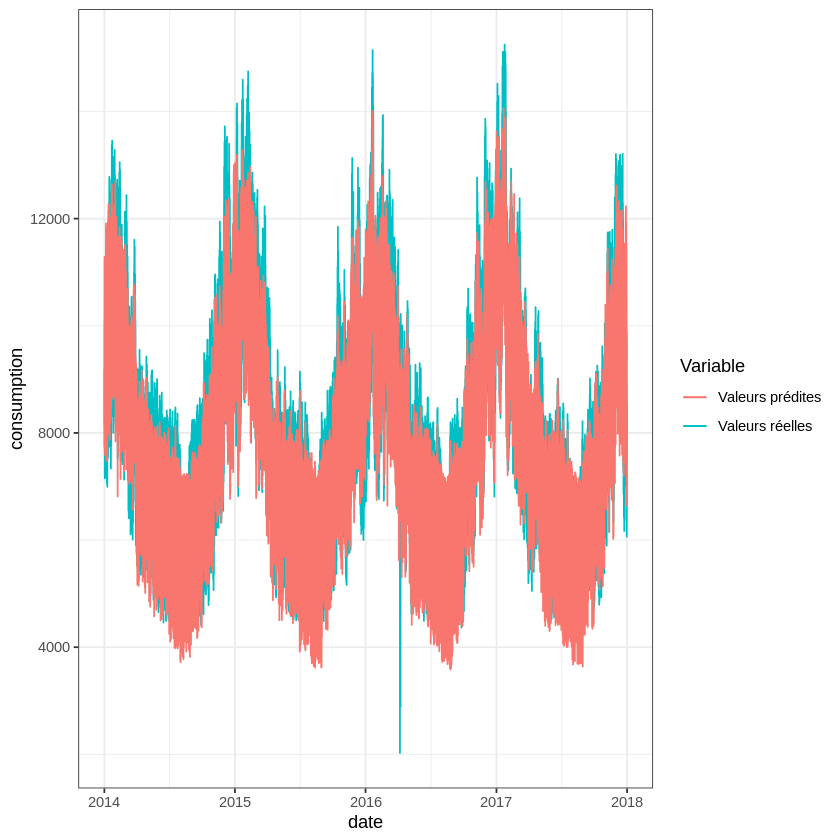

In [ ]:
ggplot(train_data, aes(x = date)) +
  geom_line(aes(y = consumption, color = "Valeurs réelles")) +
  geom_line(aes(y = fitted_gam1, color = "Valeurs prédites")) +
  labs(color = "Variable") +
  theme_bw()

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”
Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


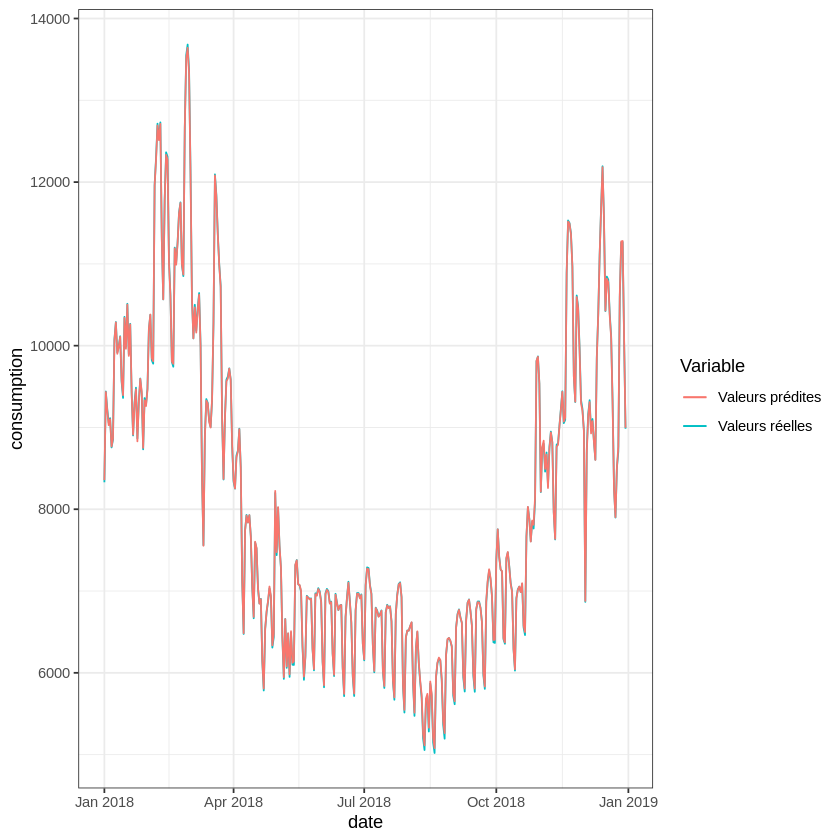

In [ ]:
ggplot(data1, aes(x = date)) +
  geom_line(aes(y = consumption, color = "Valeurs réelles")) +
  geom_line(aes(y = prediction, color = "Valeurs prédites")) +
  labs(color = "Variable") +
  theme_bw()

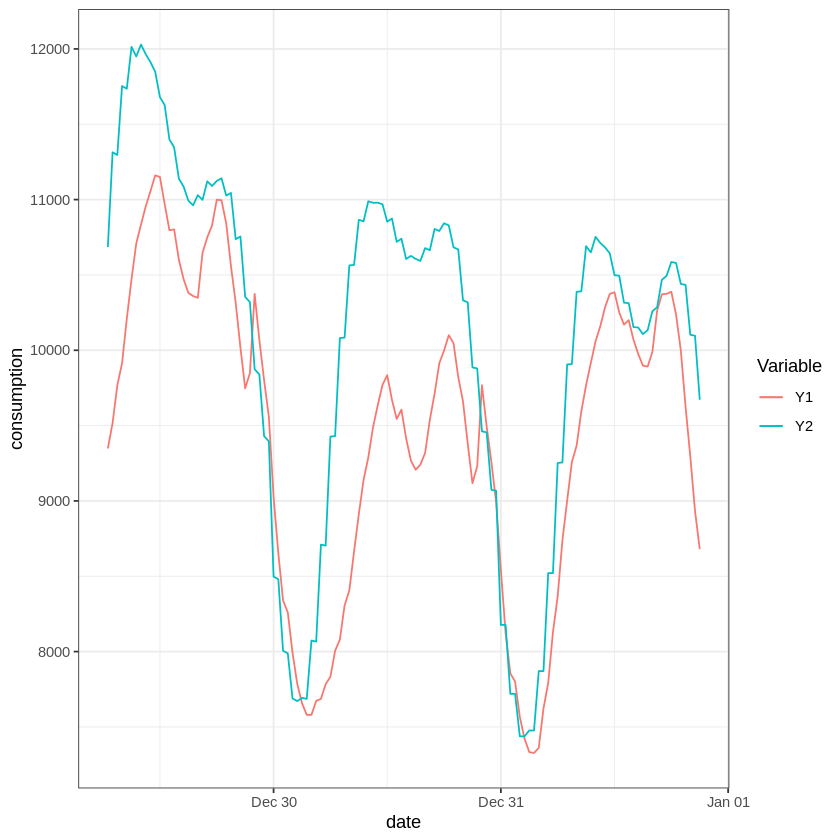

In [ ]:
subset_test_data <- subset(test_data, date >= "2018-12-29 06:30:00" & date <= "2018-12-31 21:00:00")

ggplot(subset_test_data, aes(x = date)) +
  geom_line(aes(y = consumption, color = "Y1")) +
  geom_line(aes(y = pred_gam1, color = "Y2")) +
  labs(color = "Variable") +
  theme_bw()